In [35]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import nltk
import re, string 
import pandas as pd 
from time import time  
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
%matplotlib inline

In [36]:
df = pd.read_csv('bbc-text.csv')

In [37]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [38]:
def updater(text):
    text = text.lower()
    text = re.sub("[^A-Za-z']+", ' ', text)
    
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

df_clean = pd.DataFrame(df.text.apply(lambda x: updater(x)))

In [39]:
df_clean.head()

,text
0,tv future hands viewers home theatre systems p...
1,worldcom boss left books alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...
3,yeading face newcastle fa cup premiership side...
4,ocean twelve raids box office ocean twelve cri...


In [40]:
nlp = spacy.load('en', disable=['ner', 'parser']) 
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['text']), axis=1)

In [41]:
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')

In [42]:
print(df_clean['text_lemmatize_clean'])

0       tv future hand viewer home theatre system plas...
1       worldcom boss leave book alone former worldcom...
2       tigers wary farrell gamble leicester say rush ...
3       yeade face newcastle fa cup premiership side n...
4       ocean twelve raid box office ocean twelve crim...
5       howard hit back mongrel jibe michael howard sa...
6       blair prepare name poll date tony blair likely...
7       henman hope end dubai third seed tim henman sl...
8       wilkinson fit face edinburgh england captain j...
9       last star war child sixth final star war movie...
10      berlin cheers anti nazi film german movie anti...
11      virgin blue share plummet share australian bud...
12      crude oil price back cold weather across part ...
13      hague give pm ambition former conservative lea...
14      moya emotional davis cup win carlos moya descr...
15      korean credit card firm rescue south korea lar...
16      howard back stem cell research michael howard ...
17      connor

In [43]:
tokenized_corpus = [row.split() for row in df_clean['text_lemmatize_clean']]

In [44]:
# min_count: minimum number of occurrences of a word in the corpus
# window: the maximum distance between the current and predicted word
# size: dimension of feature vectors
# workers: cores 
w2v_m = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     workers=4)

In [45]:
# this line of code to prepare the model vocabulary
w2v_m.build_vocab(tokenized_corpus, progress_per=10000)

In [46]:
# train word vectors
w2v_m.train(tokenized_corpus, total_examples=w2v_m.corpus_count, epochs=30, report_delay=1)

(11778710, 14560950)

In [47]:
# vocabulary 
vocab=list(w2v_m.wv.vocab)
print(type(vocab))
print(vocab)

<class 'list'>
['tv', 'future', 'hand', 'viewer', 'home', 'theatre', 'system', 'high', 'definition', 'digital', 'video', 'recorder', 'move', 'live', 'room', 'way', 'people', 'watch', 'different', 'five', 'year', 'time', 'accord', 'expert', 'panel', 'gather', 'annual', 'consumer', 'electronic', 'show', 'las', 'vegas', 'discuss', 'new', 'technology', 'impact', 'one', 'favourite', 'lead', 'trend', 'programme', 'content', 'deliver', 'via', 'network', 'cable', 'satellite', 'telecom', 'company', 'broadband', 'service', 'provider', 'front', 'portable', 'device', 'talk', 'personal', 'set', 'top', 'box', 'like', 'us', 'uk', 'sky', 'allow', 'record', 'store', 'play', 'pause', 'forward', 'wind', 'want', 'much', 'also', 'build', 'big', 'business', 'japan', 'take', 'europe', 'lack', 'advert', 'forget', 'channel', 'schedule', 'put', 'together', 'la', 'entertainment', 'worry', 'mean', 'term', 'advertising', 'revenue', 'well', 'brand', 'identity', 'although', 'moment', 'concern', 'raise', 'particularl

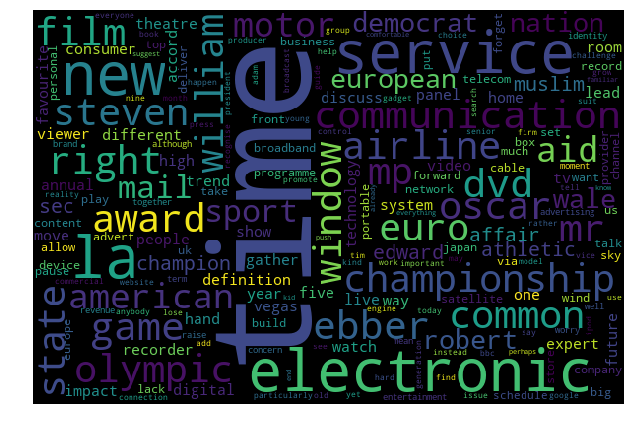

In [48]:
#visualizing our vocab with a word cloud.
from wordcloud import WordCloud
# Generate a word cloud image for positive reviews
str=''
for strings in vocab:
     str=str+strings+' '
polarity_pos_wordcloud = WordCloud(width=600, height=400).generate(str)
plt.figure( figsize=(9,9))
plt.imshow(polarity_pos_wordcloud)
plt.axis("off")
plt.tight_layout()
plt.show()

In [49]:
# Create the model
w2v_m.init_sims(replace=True)

In [50]:
# Explore the model
w2v_m.wv.most_similar(positive=['america'])

[('korea', 0.48687469959259033),
 ('asian', 0.46995478868484497),
 ('north', 0.46085092425346375),
 ('african', 0.4508294463157654),
 ('airlines', 0.4491575062274933),
 ('korean', 0.4413454532623291),
 ('eastern', 0.4322451055049896),
 ('lanka', 0.4277593195438385),
 ('latin', 0.4232017695903778),
 ('east', 0.42300814390182495)]

In [51]:
# Visualizing the model
def tsne_plot(model, wordToFind):
    "Create TSNE model and plot it"
    labels = []
    tokens = []
    
    tokens.append(model[wordToFind])
    labels.append(wordToFind)

    for word, value in model.wv.most_similar(positive=[wordToFind]):
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10))
    plt.scatter(x[0],y[0], c='#ff0000')
    plt.annotate(labels[0],
                     xy=(x[0], y[0]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    for i in range(1, len(x)):
        plt.scatter(x[i],y[i], c='#000000')
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [52]:
w2v_m.wv.vocab

{'tv': <gensim.models.keyedvectors.Vocab at 0x1a287ca908>,
 'future': <gensim.models.keyedvectors.Vocab at 0x1a2d59e518>,
 'hand': <gensim.models.keyedvectors.Vocab at 0x1a2d59e6a0>,
 'viewer': <gensim.models.keyedvectors.Vocab at 0x1a2d59e710>,
 'home': <gensim.models.keyedvectors.Vocab at 0x1a2d59e748>,
 'theatre': <gensim.models.keyedvectors.Vocab at 0x1a2d59e898>,
 'system': <gensim.models.keyedvectors.Vocab at 0x1a2d59e8d0>,
 'high': <gensim.models.keyedvectors.Vocab at 0x1a2d59e908>,
 'definition': <gensim.models.keyedvectors.Vocab at 0x1a2d59e978>,
 'digital': <gensim.models.keyedvectors.Vocab at 0x1a2d59ea20>,
 'video': <gensim.models.keyedvectors.Vocab at 0x1a2d59eac8>,
 'recorder': <gensim.models.keyedvectors.Vocab at 0x1a2d59eb00>,
 'move': <gensim.models.keyedvectors.Vocab at 0x1a2d59eba8>,
 'live': <gensim.models.keyedvectors.Vocab at 0x1a2d59ec50>,
 'room': <gensim.models.keyedvectors.Vocab at 0x1a2d59ec88>,
 'way': <gensim.models.keyedvectors.Vocab at 0x1a2d59ecc0>,
 'pe

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


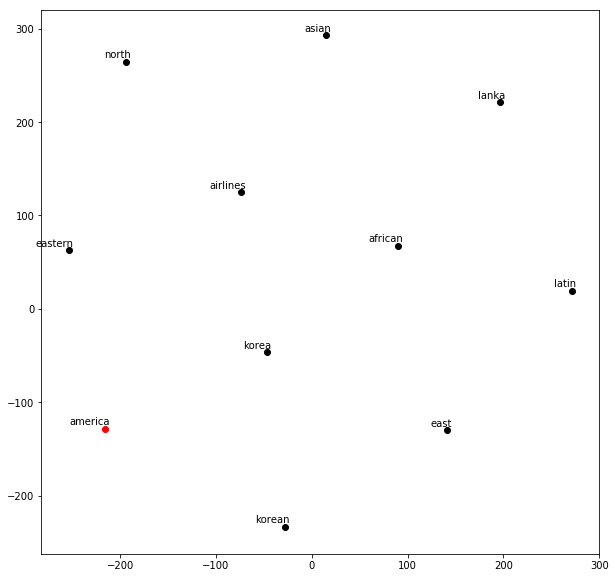

In [53]:
# 10 most similar words to "american"
tsne_plot(w2v_m, 'america')